In [6]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
#from torch import linspace
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import time
import pickle

from E_data import create_residual_data, create_IC_data,create_BC_data, initial_u,Move_Time_1D,create_RH_data,Euler_WENO
from E_Plotting import E_plot,  loss_plot 
from E_solver import exact_solver

# Full PINN
#from E_PINN_WE import NN
#from E_PINN_train_plot import pinn_train

# VGPT-PINN
from E_VGPT_PINN_test import GPT
from E_VGPT_train_minibatch import gpt_train
from E_VGPT_activation import P

#torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [7]:
# Initial and Boundary Conditions
rhoL = 1.0
uL = 0.0
PL = 1.0
rhoR = 0.125
uR = 0.0
PR = 0.1
ini=[rhoL,PL,uL, rhoR,PR,uR]

# Domain and Data
Xi, Xf         =  0.0, 1.0
Ti, Tf         =  0.0, 0.1
Nc, N_test     =  100, 100
Tc, T_test     =  200, 100
N_simple       =  5000
IC_pts         =  100 
N_RH           =  100
dx = 0.01
dt = 0.002

gamma =1.4
number_of_parameters = 5
number_of_neurons = 5
nu_training = np.linspace(1,2, number_of_parameters)

residual_data = create_residual_data(Xi, Xf, Ti, Tf, Nc, N_test,Tc,T_test,N_simple)
xt_resid      = residual_data[0].to(device)
f_hat         = residual_data[1].to(device)
xt_test       = residual_data[2].to(device) 

xt_RH_data = create_RH_data(Xi, Xf, Ti, Tf, IC_pts, N_RH,dx)
xt_RH = xt_RH_data[0].to(device)
xt_RHL = xt_RH_data[1].to(device)

In [8]:
P_list = np.ones(number_of_neurons, dtype=object)
with open('PINNWE0410_Sod010_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[0] = PINN
with open('PINNWE0410_Sod015_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[1] = PINN
with open('PINNWE0410_Sod020_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[2] = PINN
with open('PINNWE0410_Sod012_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[3] = PINN
with open('PINNWE0410_Sod017_t01.pkl', 'rb') as f:
    PINN = pickle.load(f)
    P_list[4] = PINN

In [9]:
lr_pinn     = 0.001
epochs_pinn = [25000,20000,25000,25000]
layers_pinn = np.array([2, 60, 60,60,60,60, 3])
#layers_pinn = np.array([2, 30, 30,30,30, 3])
tol         = [1e-3,1e-4]

lr_vgpt          = 0.0001
epochs_vgpt      = [2000,10000]
tol_vgpt         = 1e-2

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: Loss: 36.681565
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 36.68156510220032
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 18.675776
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 18.631339
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 1500 | Loss: 18.582015
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 18.535995
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0046e+00,  6.4514e-04],
        [-9.7687e-03,  9.9951e-01]], device='cuda:0', dtype=torch.float64) and tensor([[0.2500, 0.2500, 0.2500, 0.2500]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2500, 

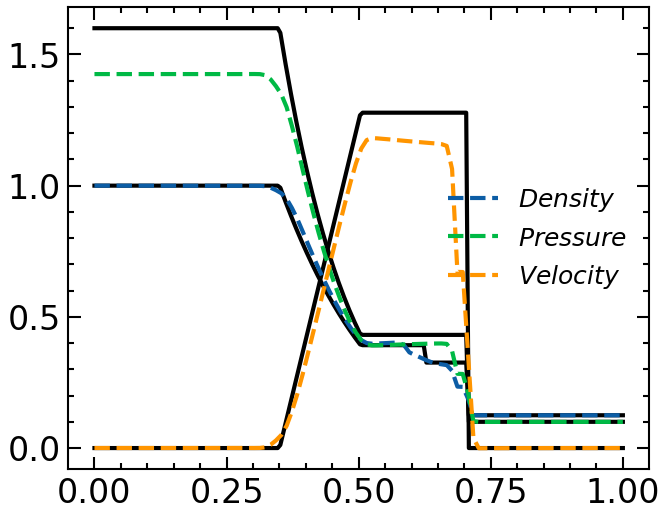

Step 2 Training Begin...
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.5594,  6.7877],
        [-0.1678,  9.5150]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0926, -0.0016],
        [-0.0526,  0.9996]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[6.0323e-02, 5.2251e-04, 8.5535e-03, 9.6912e-01]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.0577, -0.0052, -0.0017,  1.2710]], device='cuda:0',
       dtype=torch.float64),tensor([[ 4.5813e-02, -6.0181e-04, -6.5549e-03,  1.1001e+00]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.262811


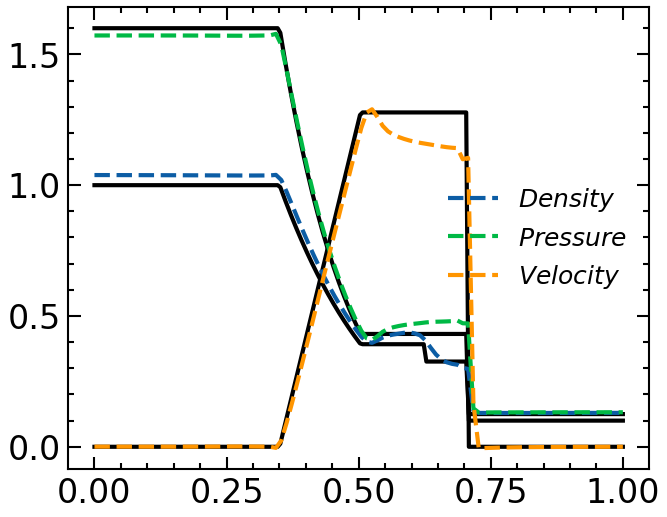

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.1080, 11.8288],
        [ 0.0552, 32.9995]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1119, -0.0016],
        [-0.0285,  0.9996]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 2.6276e-02, -9.6309e-04,  3.7600e-03,  9.9963e-01]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.0159,  0.0109, -0.0022,  1.3077]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.0185, -0.0021, -0.0043,  1.1473]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 6000 | Loss: 0.187874


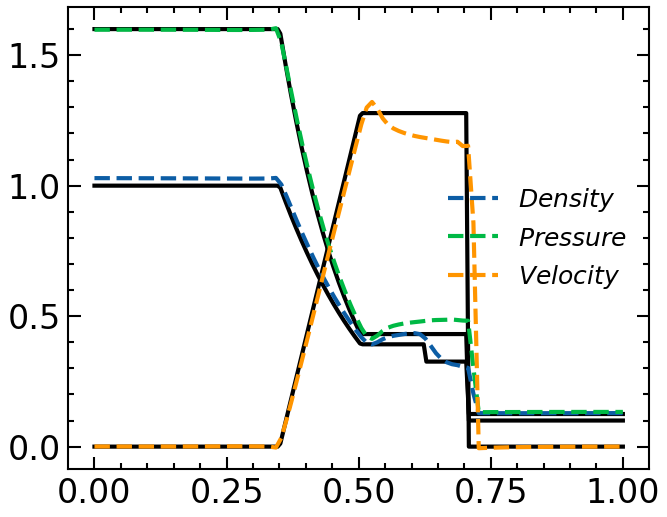

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ -2.0179, -15.5297],
        [  1.1085,  16.8813]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1266, -0.0018],
        [-0.0039,  1.0000]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.0020,  0.0631, -0.0020,  0.9353]], device='cuda:0',
       dtype=torch.float64),tensor([[ 1.7090e-02,  8.6187e-02, -7.2569e-04,  1.2094e+00]], device='cuda:0',
       dtype=torch.float64),tensor([[ 0.0208,  0.0543, -0.0014,  1.0693]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 8000 | Loss: 0.141283


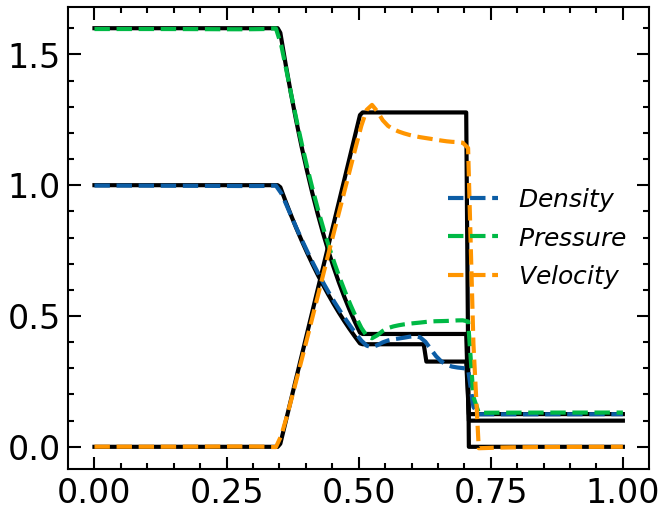

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.2040,  0.0071],
        [-0.0575,  0.9959]], device='cuda:0', dtype=torch.float64) and tensor([[ 2.1403e-02,  2.0325e-01, -5.4332e-04,  7.6684e-01]], device='cuda:0',
       dtype=torch.float64),tensor([[0.0735, 0.1789, 0.0024, 1.0474]], device='cuda:0',
       dtype=torch.float64),tensor([[0.0656, 0.1423, 0.0052, 0.9296]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 10000 | Loss: 0.135997 (TGPT_PINN2 Step Criteria Met)



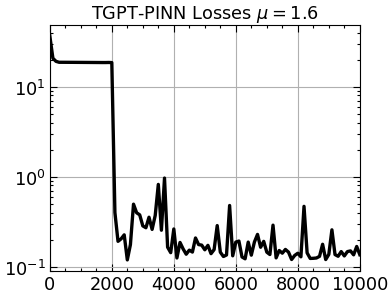

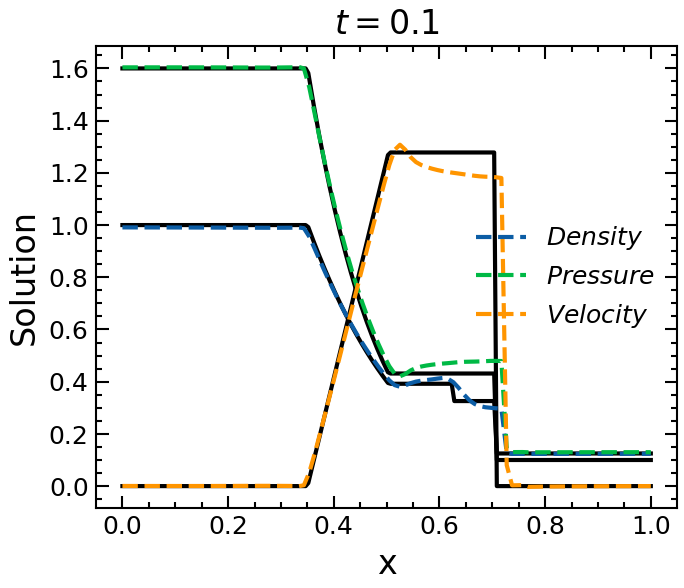

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64) and tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64),tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: Loss: 44.525318
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]: Epoch: 0 | Loss: 44.525317785277856
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 500 | Loss: 16.865123
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 1000 | Loss: 16.770957
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 1500 | Loss: 16.657012
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 2000 | Loss: 16.538498
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.0051,  0.0011],
        [-0.0061,  0.9984]], device='cuda:0', dtype=torch.float64) and tensor([[0.2000, 0.2000, 0.2000, 0.2000, 0.2000]], device='cuda:0',
       dtype=torch.float64),

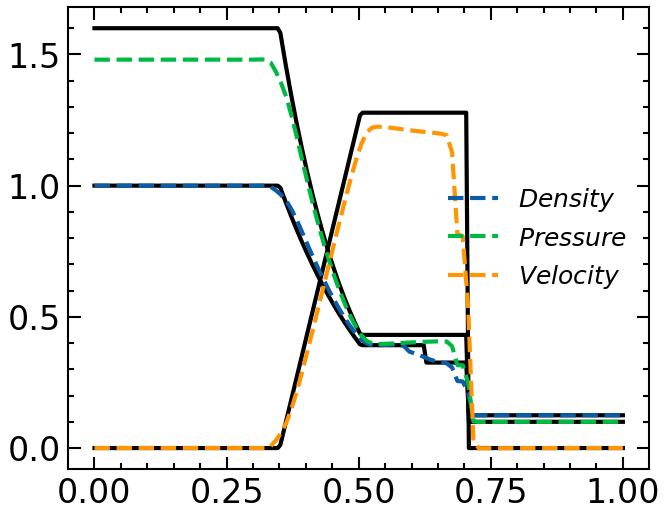

Step 2 Training Begin...
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 0.0010,  0.0412],
        [-0.0004,  0.0337]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0436,  0.0028],
        [-0.0562,  0.9965]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 4.6405e-06,  7.6056e-01, -1.7646e-03,  3.0699e-02,  2.1416e-01]],
       device='cuda:0', dtype=torch.float64),tensor([[ 1.7080e-03,  7.7885e-01, -1.5869e-04,  3.6900e-02,  2.2692e-01]],
       device='cuda:0', dtype=torch.float64),tensor([[1.9194e-04, 7.8591e-01, 6.6819e-04, 3.5163e-02, 2.0211e-01]],
       device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 4000 | Loss: 0.052034


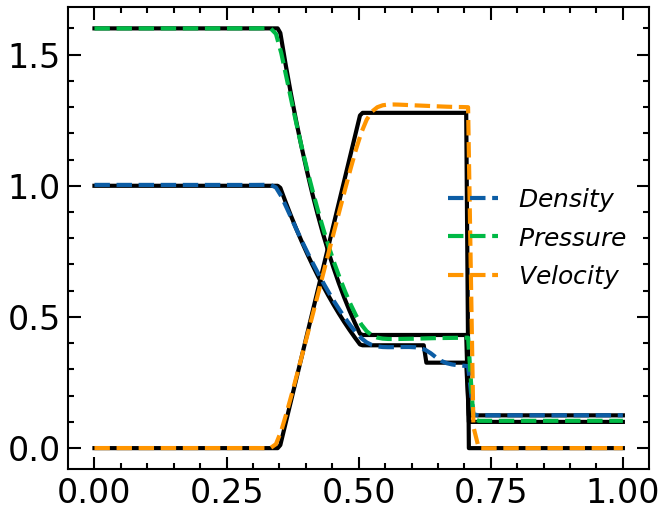

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0129,  0.2657],
        [-0.0100,  0.3977]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.0941,  0.0108],
        [-0.0887,  0.9921]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[5.9324e-03, 8.6321e-01, 4.2169e-04, 1.2620e-01, 1.3751e-03]],
       device='cuda:0', dtype=torch.float64),tensor([[1.2680e-02, 9.3076e-01, 2.5199e-03, 1.4413e-01, 2.9681e-04]],
       device='cuda:0', dtype=torch.float64),tensor([[0.0093, 0.9002, 0.0032, 0.1352, 0.0033]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 6000 | Loss: 0.127077


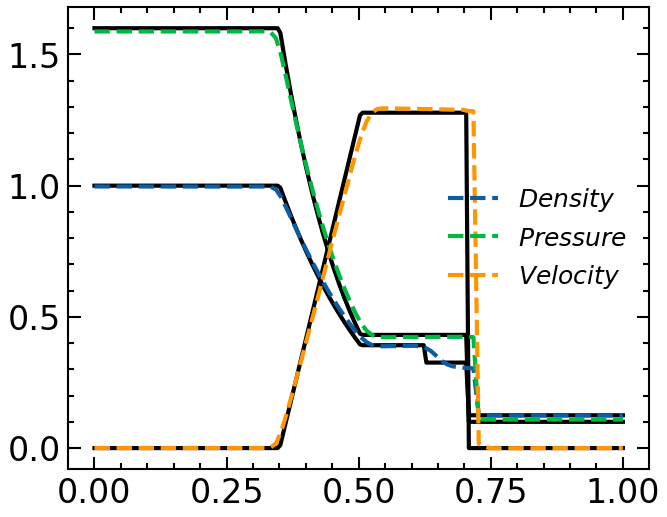

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[-0.0893, -0.4339],
        [ 0.0161,  0.8937]], device='cuda:0', dtype=torch.float64) and tensor([[ 1.1204,  0.0120],
        [-0.0978,  0.9904]], device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 2.0098e-02,  8.4187e-01,  2.6794e-03,  1.3432e-01, -9.5956e-05]],
       device='cuda:0', dtype=torch.float64),tensor([[0.0330, 0.9081, 0.0013, 0.1601, 0.0011]], device='cuda:0',
       dtype=torch.float64),tensor([[0.0244, 0.8654, 0.0085, 0.1476, 0.0049]], device='cuda:0',
       dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 8000 | Loss: 0.124072


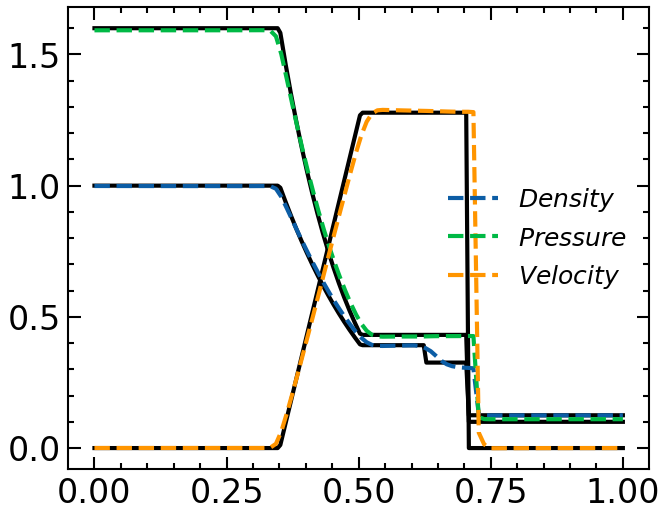

[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:tensor([[ 1.1254,  0.0137],
        [-0.0754,  0.9838]], device='cuda:0', dtype=torch.float64) and tensor([[ 2.7025e-03,  9.9859e-01, -4.6730e-04,  2.7026e-03,  1.6694e-03]],
       device='cuda:0', dtype=torch.float64),tensor([[-8.4894e-04,  1.0572e+00,  1.2760e-03,  2.0182e-03, -8.2631e-04]],
       device='cuda:0', dtype=torch.float64),tensor([[5.3074e-03, 1.0247e+00, 1.2365e-04, 8.7495e-04, 2.0275e-04]],
       device='cuda:0', dtype=torch.float64)
[1.0, 1.6, 0.0, 0.125, 0.1, 0.0]:Epoch: 10000 | Loss: 0.131583 (TGPT_PINN2 Step Criteria Met)



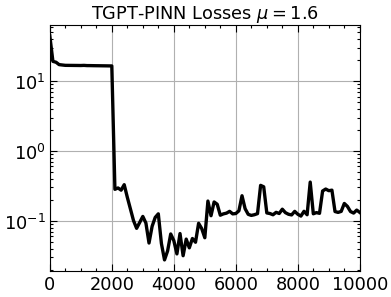

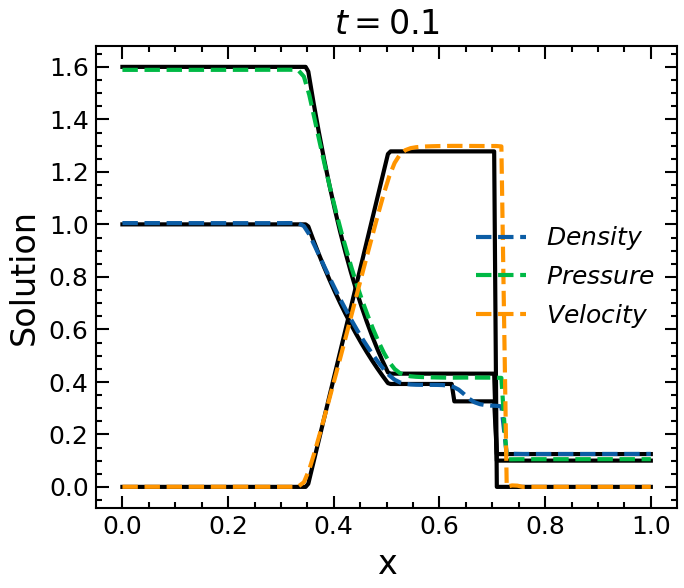

In [10]:
ini[1] = 1.6
weno_u = exact_solver([ini[0],ini[2],ini[1]],[ini[3],ini[5],ini[4]],gamma,Tf,N=200)
IC_data = create_IC_data(ini,Xi, Xf, Ti, Tf, IC_pts)
IC_xt     = IC_data[0].to(device)
IC_u      = IC_data[1]

BC_data = create_BC_data(ini,Xi, Xf, Ti, Tf, IC_pts)
BC_xt     = BC_data[0].to(device)
BC_u      = BC_data[1]

for i in range(3,number_of_neurons):
    layers_gpt = np.array([2, i+1, 3])
    c_initial  = torch.full((1,i+1), 1/(i+1))

    xt_en = Move_Time_1D(IC_xt, Tf).to(device)
    #weno_u = Euler_WENO(Xi,Xf,Ti,Tf,ini,gamma,delta_t=0.0001,delta_x=0.005)
    VGPT_PINN = GPT(ini, layers_gpt, P_list[0:i+1], c_initial, Nc, Tc, gamma,Tf).to(device).double()

    vgpt_losses = gpt_train(VGPT_PINN, ini, xt_resid,  IC_xt, IC_u,BC_xt, BC_u, f_hat,xt_test,xt_en, xt_RH, xt_RHL,weno_u,  epochs_vgpt, lr_vgpt, tol_vgpt)

    loss_plot(vgpt_losses[1], vgpt_losses[2], dpi=80, figsize=(5,4),title=fr"VGPT-PINN Losses $\mu={round(ini[1],3)}$")

    Nx_test=N_test
    Nt_test=T_test
    plt.figure(dpi=150, figsize=(5,4))

    ind = 100
    plt.plot(weno_u[3],weno_u[0],'k')#,label="$Density$"
    plt.plot(weno_u[3],weno_u[1],'k')#,label="$Pressure$"
    plt.plot(weno_u[3],weno_u[2],'k')#,label="$velocity$"

    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,0:1][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Density$")
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,1:2][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Pressure$")
    #plt.plot(xt_test[0::Nt_test,1].detach().cpu(),P_list[0](xt_test)[:,2:][ind-1::Nx_test].detach().cpu(),'k',label=fr"$Velocity$")

    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),VGPT_PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),VGPT_PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
    plt.plot(xt_test[0::Nt_test,1].detach().cpu(),VGPT_PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
    plt.xlabel("x",     fontsize=16)
    plt.ylabel("Solution", fontsize=16)
    plt.title(fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

    plt.legend(fontsize = 12)#
    plt.show()